In [2]:
# !pip install jcopdl==1.1.1

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12587 sha256=3eeb15e851fb5dcccfd4a1af56ff10a0dbeb4d5a87c9934f30c5374152199c22
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl


In [3]:
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/.DS_Store     
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._.DS_Store  
   creating: data/test/9/
  inflating: data/test/9/176.png     
  inflating: data/test/9/162.png     
  inflating: data/test/9/189.png     
  inflating: data/test/9/200.png     
  inflating: data/test/9/188.png     
  inflating: data/test/9/163.png     
  inflating: data/test/9/177.png     
  inflating: data/test/9/161.png     
  inflating: data/test/9/175.png     
  inflating: data/test/9/174.png     
  inflating: data/test/9/160.png     
  inflating: data/test/9/164.png     
  inflating: data/test/9/170.png     
  inflating: data/test/9/171.png     
  inflating: data/test/9/165.png     
  inflating: data/test/9/173.png     
  inflating: data/test/9/167.png     
  inflating: data/t

# Dataset & Dataloader

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

bs = 64

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Arsitektur & Config

In [6]:
from jcopdl.layers import linear_block

class AutoEncoder(nn.Module):
    def __init__(self, z_size):
        super().__init__()

        self.encode = nn.Sequential(
            linear_block(784, 512, batch_norm=True),
            linear_block(512, 256, batch_norm=True),
            linear_block(256, z_size, activation='sigmoid')
        )

        self.decode = nn.Sequential(
            linear_block(z_size, 256, batch_norm=True),
            linear_block(256, 512, batch_norm=True),
            linear_block(512, 784, activation='sigmoid')
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x



In [7]:
config = set_config({
    "z_size": 32,
    "batch_size": bs
})

# Training Preparation -> MCOC

In [8]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/ae')

# Training

In [9]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)

        output = model(feature)
        loss = criterion(output, feature)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3344 | Test_cost  = 0.2607 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1829 | Test_cost  = 0.1728 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1587 | Test_cost  = 0.1517 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1446 | Test_cost  = 0.1403 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1347 | Test_cost  = 0.1334 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


    AssertionErrorTraceback (most recent call last):
self._shutdown_workers():   File "/usr/local/lib/python3.10/dist-packages/torch/uti

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1281 | Test_cost  = 0.1283 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1228 | Test_cost  = 0.1250 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1183 | Test_cost  = 0.1194 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1139 | Test_cost  = 0.1171 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1103 | Test_cost  = 0.1148 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1071 | Test_cost  = 0.1123 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1045 | Test_cost  = 0.1104 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1024 | Test_cost  = 0.1095 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1004 | Test_cost  = 0.1080 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0979 | Test_cost  = 0.1067 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0974 | Test_cost  = 0.1072 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1067


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0963 | Test_cost  = 0.1051 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>Exception ignored in: 

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c1bdd08e9e0>
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    self._shutdown_workers()    self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0943 | Test_cost  = 0.1042 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0933 | Test_cost  = 0.1037 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0920 | Test_cost  = 0.1036 | 


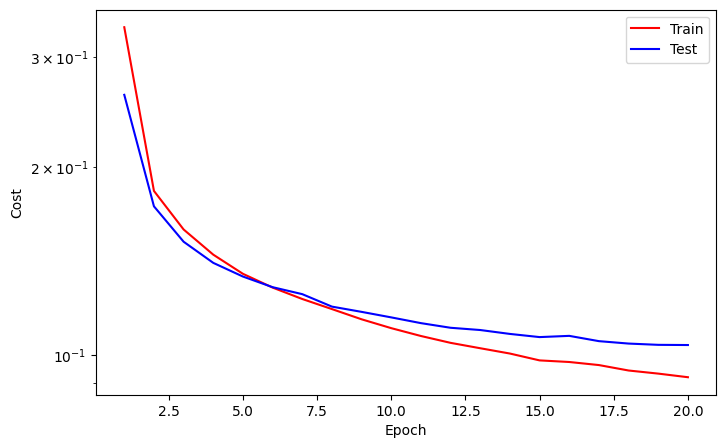

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0913 | Test_cost  = 0.1025 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0904 | Test_cost  = 0.1019 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0895 | Test_cost  = 0.1014 | 


Train:   0%|          | 0/25 [01:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0894 | Test_cost  = 0.1021 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1014


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0886 | Test_cost  = 0.1017 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1014


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0874 | Test_cost  = 0.1014 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0867 | Test_cost  = 0.1008 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0861 | Test_cost  = 0.1004 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0853 | Test_cost  = 0.1001 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0846 | Test_cost  = 0.1005 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1001


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0848 | Test_cost  = 0.1003 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1001


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0848 | Test_cost  = 0.0999 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0839 | Test_cost  = 0.0994 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0833 | Test_cost  = 0.0994 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0825 | Test_cost  = 0.0991 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0828 | Test_cost  = 0.0991 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0821 | Test_cost  = 0.0991 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0991


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0818 | Test_cost  = 0.0990 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0813 | Test_cost  = 0.0990 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0990


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0809 | Test_cost  = 0.0985 | 


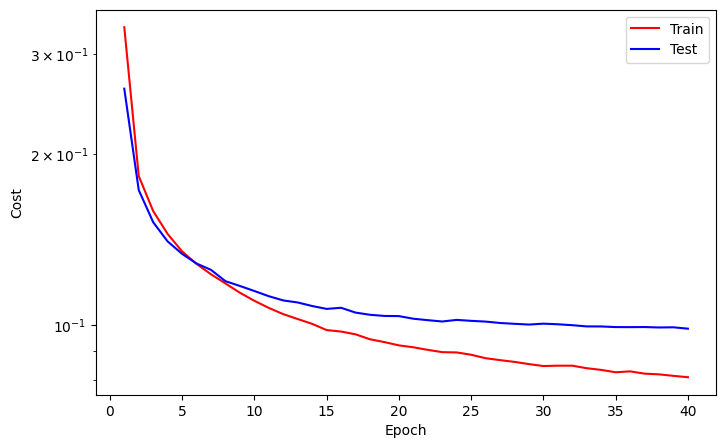

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0804 | Test_cost  = 0.0992 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0985


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0801 | Test_cost  = 0.0988 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0985


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0799 | Test_cost  = 0.0987 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0985


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.0801 | Test_cost  = 0.0990 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0985


Train:   0%|          | 0/25 [01:20<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.0797 | Test_cost  = 0.0986 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0985
==> Execute Early Stopping at epoch: 45 | Best test_cost: 0.0985
==> Best model is saved at model/ae


/usr/local/lib/python3.10/dist-packages/jcopdl/callback/_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f'{self.outdir}/weights_best.pth

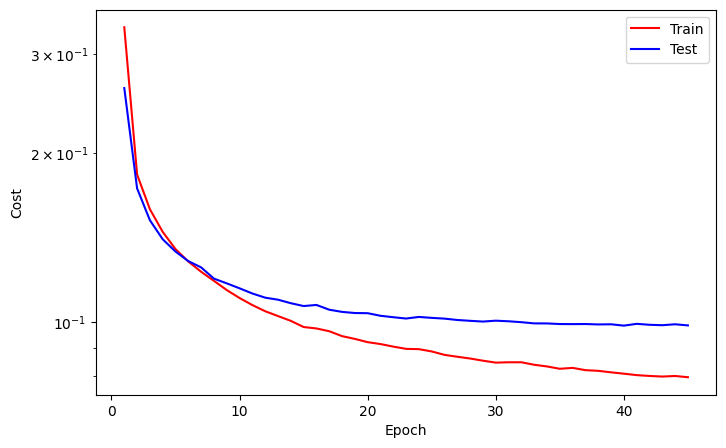

In [10]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break


# Evaluate

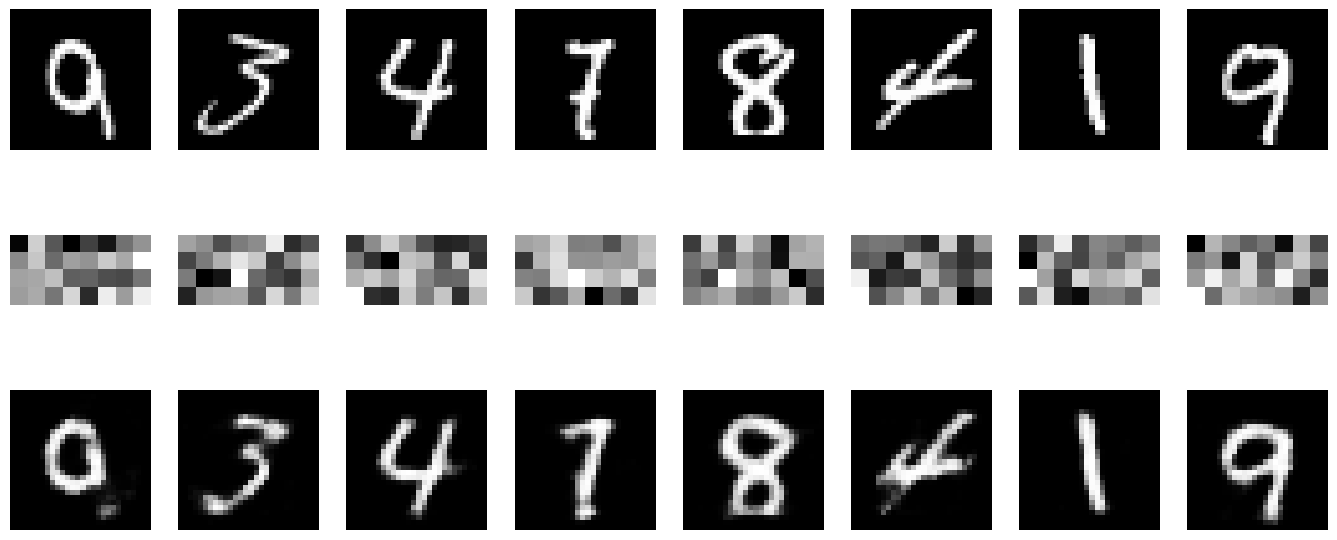

In [11]:
import matplotlib.pyplot as plt
feature, target = next(iter(testloader))
feature = feature.view(-1, 784).to(device)

with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')


# Playground

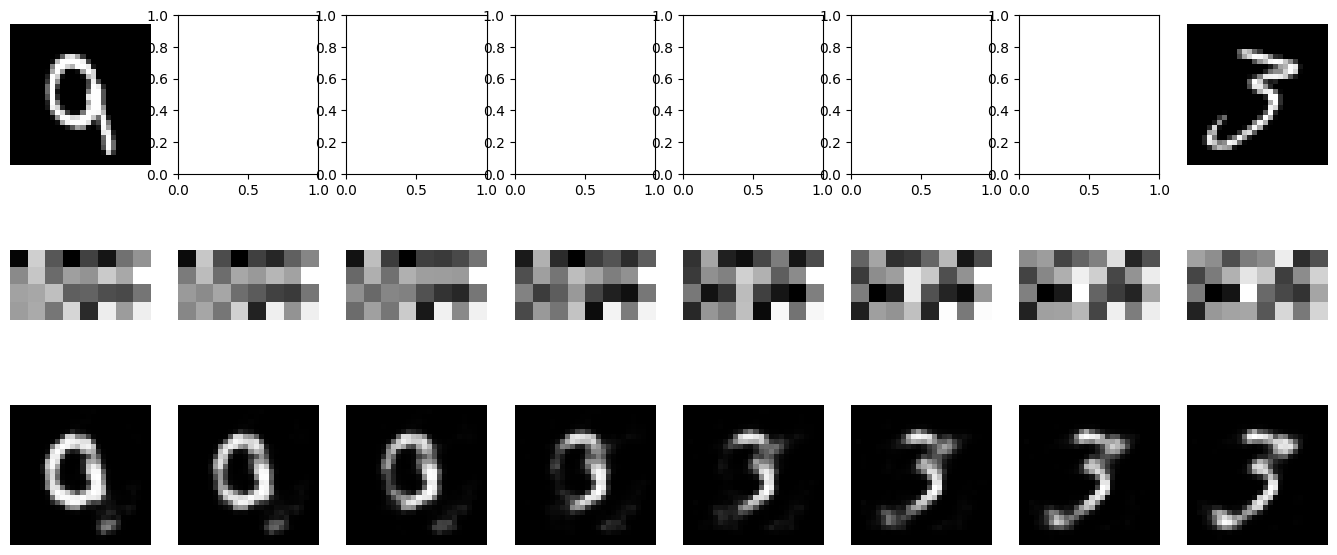

In [12]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)

    code1, code2 = enc[0], enc[1]
    codes = [(1-i)*code1 + i*code2 for i in np.linspace(0, 1, 8)]
    enc = torch.stack(codes)

    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))

ax[0, 0].imshow(feature[0].view(28, 28).cpu(), cmap='gray')
ax[0, 0].axis('off')
ax[0, 7].imshow(feature[1].view(28, 28).cpu(), cmap='gray')
ax[0, 7].axis('off')

for i in range(8):
    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')


# Denoising AutoEncoder

In [13]:
def add_noise(images, noise_factor=0.5):
    images = torch.clone(images)
    images += noise_factor * torch.rand_like(images)
    # karna vector image sudah dikalikan dengan noise yang ditentukan
    # maka harus dibatasi vectornya dalam hal ini 0 - 1
    images = images.clamp(0., 1.)
    return images



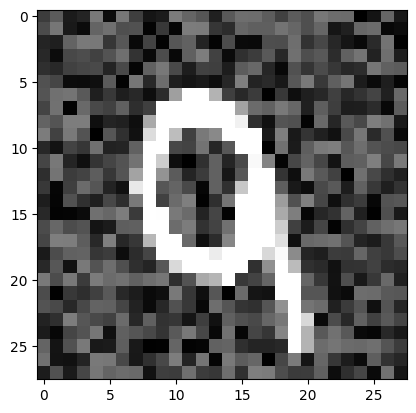

In [14]:
plt.imshow(add_noise(feature[0]).view(28, 28).cpu(), cmap="gray")

# Training Preparation -> MCOC

In [15]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/dae')

# Training

## fiturnya sendiri adalah target

In [16]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)

        output = model(add_noise(feature))
        loss = criterion(output, feature)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3366 | Test_cost  = 0.2607 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1864 | Test_cost  = 0.1789 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1634 | Test_cost  = 0.1570 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1501 | Test_cost  = 0.1469 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1404 | Test_cost  = 0.1395 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1339 | Test_cost  = 0.1345 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1283 | Test_cost  = 0.1293 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1235 | Test_cost  = 0.1260 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1201 | Test_cost  = 0.1232 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1156 | Test_cost  = 0.1204 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1133 | Test_cost  = 0.1179 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1108 | Test_cost  = 0.1168 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1093 | Test_cost  = 0.1162 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1073 | Test_cost  = 0.1137 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1055 | Test_cost  = 0.1130 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1039 | Test_cost  = 0.1129 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1023 | Test_cost  = 0.1115 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1014 | Test_cost  = 0.1107 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1004 | Test_cost  = 0.1093 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0987 | Test_cost  = 0.1099 | 


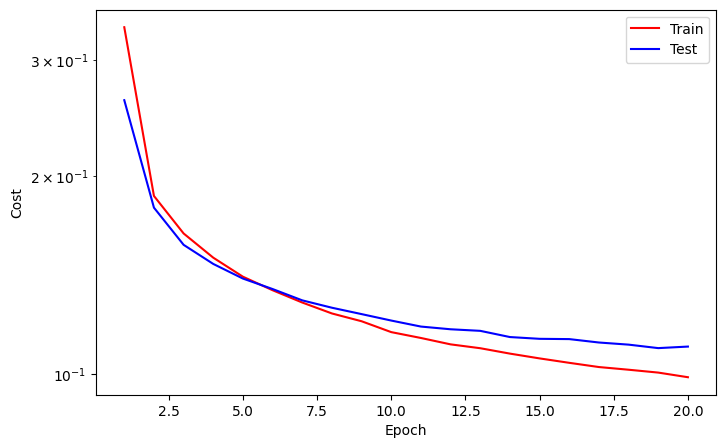

==> EarlyStop patience =  1 | Best test_cost: 0.1093


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0985 | Test_cost  = 0.1089 | 


Train:   0%|          | 0/25 [00:20<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0966 | Test_cost  = 0.1074 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0960 | Test_cost  = 0.1075 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1074


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0953 | Test_cost  = 0.1073 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0940 | Test_cost  = 0.1072 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0932 | Test_cost  = 0.1056 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0930 | Test_cost  = 0.1055 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0922 | Test_cost  = 0.1056 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1055


Train:   0%|          | 0/25 [02:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0915 | Test_cost  = 0.1064 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1055


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0918 | Test_cost  = 0.1062 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1055


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0906 | Test_cost  = 0.1057 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1055


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0909 | Test_cost  = 0.1051 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0901 | Test_cost  = 0.1044 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0889 | Test_cost  = 0.1033 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0881 | Test_cost  = 0.1036 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1033


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0884 | Test_cost  = 0.1045 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1033


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0883 | Test_cost  = 0.1042 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1033


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0878 | Test_cost  = 0.1040 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1033


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0870 | Test_cost  = 0.1037 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1033
==> Execute Early Stopping at epoch: 39 | Best test_cost: 0.1033
==> Best model is saved at model/dae


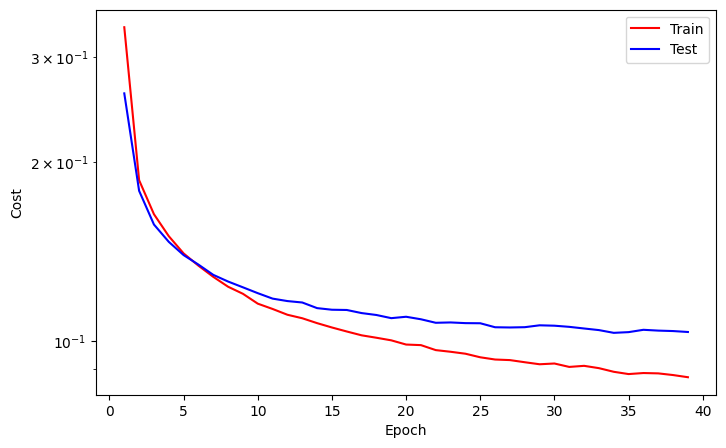

In [17]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break


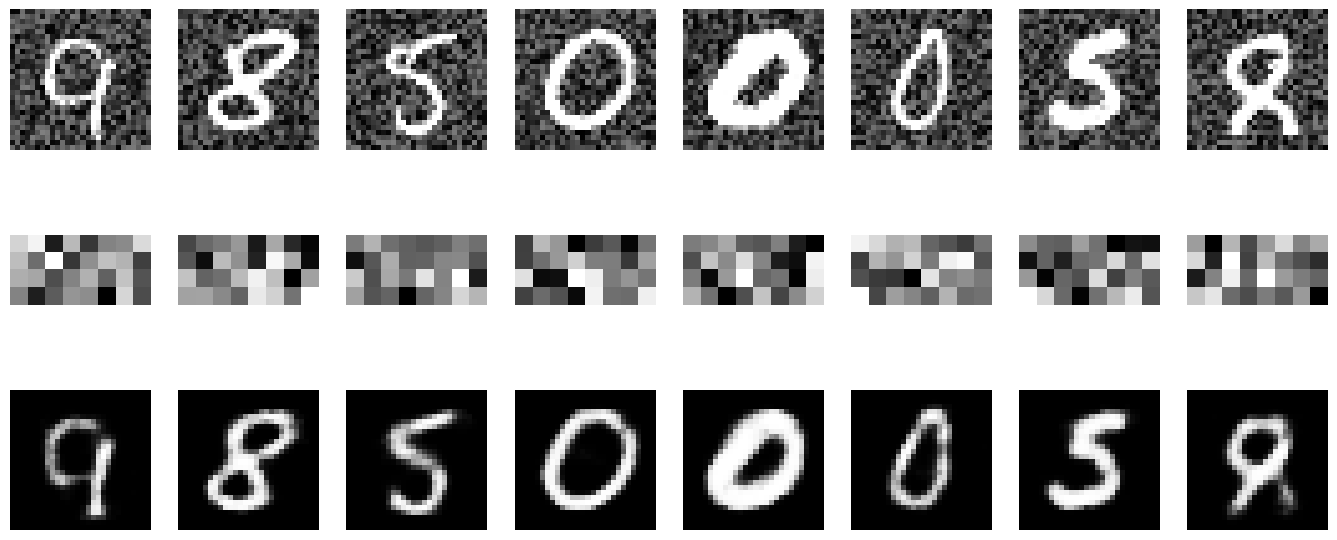

In [18]:
import matplotlib.pyplot as plt
feature, target = next(iter(testloader))
feature = add_noise(feature).view(-1, 784).to(device)

with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')
